In [1]:
from typing import Dict, Tuple
import os
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [2]:
fluxes = {
    "Slow": 5e-4,
    "Normal": 5e-3,
    "Fast": 5e-2,
    "FFast": 5e-1,
    "FFFast": 5,
    "FFFFast": 50,
}

folder_path_tepem = "/Users/erikweilandt/Documents/university/master_thesis/tepem/results"
folder_path_elena = "/Users/erikweilandt/Library/Mobile Documents/com~apple~CloudDocs/University/MSc Mathematics Como/master_thesis/sims_elena/HStokes"
results_path = "/Users/erikweilandt/Documents/university/master_thesis/tepem/results/plots"

elena_p_file_name = 'p240_newtoniano'
elena_u_file_name = 'u240_newtoniano'
tepem_p_file_name = 'p_lr'
tepem_u_file_name = 'u_hr'

In [3]:
def get_tepem_folder_names(fluxes: dict[str, float], num_slabs: int) -> dict[str,str]:
    folder_names = {speed : f"nozzles_n{num_slabs}_q{speed}" for speed in fluxes.keys()}
    return folder_names

def get_elena_folder_names(fluxes: dict[str, float], degree: int) -> dict[str,str]:
    folder_names = {speed : f"HStokes{speed}{str(degree)}" for speed in fluxes.keys()}
    return folder_names

elenas_folder = get_elena_folder_names(fluxes=fluxes,degree=5)
tepems_folder = get_tepem_folder_names(fluxes=fluxes, num_slabs=10)

In [4]:
def read_csv_files_to_dict(folder_path: str) -> Dict[str, npt.NDArray[np.float64]]:
    data_dict: Dict[str,npt.NDArray[np.float64]] = {}

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            key = file_name[:-4]  # Remove the '.csv' extension to get the key name

            # Read the CSV file into a NumPy array and store in the dictionary
            try:
                data_dict[key] = np.loadtxt(file_path, delimiter=',', dtype=np.float64)
            except:
                data_dict[key] = np.loadtxt(file_path, dtype=np.float64)

    return data_dict

def process_subfolders(directory_path: str, folder_names: dict[str,str]) -> Dict[str, Dict[str, npt.NDArray[np.float64]]]:
    result_dict: Dict[str, Dict[str, npt.NDArray[np.float64]]] = {}

    for subfolder in os.listdir(directory_path):
        if subfolder in folder_names.values():
            subfolder_path = os.path.join(directory_path, subfolder)
            if "H5" in os.listdir(subfolder_path):
                subfolder_path = os.path.join(subfolder_path, "H5")
            if os.path.isdir(subfolder_path):
                try:
                    folder_id = list(folder_names.keys())[list(folder_names.values()).index(subfolder)]  # Extract the number from the subfolder name
                    result_dict[folder_id] = read_csv_files_to_dict(subfolder_path)
                except ValueError:
                    print(f"Could not load folder: {subfolder}")


    return result_dict

In [5]:
elenas_data = process_subfolders(directory_path=folder_path_elena, folder_names=elenas_folder)
tepems_data = process_subfolders(directory_path=folder_path_tepem, folder_names=tepems_folder)
elenas_data

{'Slow': {'p240_newtoniano': array([[ 5.000000e-10, -1.250000e-02,  0.000000e+00,  3.437584e+01],
         [ 1.250000e-04, -1.250000e-02,  0.000000e+00,  3.437196e+01],
         [ 2.500000e-04, -1.250000e-02,  0.000000e+00,  3.436808e+01],
         ...,
         [ 1.197500e-01,  3.751130e-03,  0.000000e+00,  2.872037e-01],
         [ 1.198750e-01,  3.751130e-03,  0.000000e+00,  1.436018e-01],
         [ 1.200000e-01,  3.751130e-03,  0.000000e+00,  5.733242e-07]]),
  'u240_newtoniano': array([[ 2.500000e-10, -1.250000e-02,  0.000000e+00,  0.000000e+00,
          -0.000000e+00,  0.000000e+00],
         [ 6.250000e-05, -1.250000e-02,  0.000000e+00,  0.000000e+00,
           0.000000e+00,  0.000000e+00],
         [ 1.250000e-04, -1.250000e-02,  0.000000e+00,  0.000000e+00,
           0.000000e+00,  0.000000e+00],
         ...,
         [ 1.198750e-01,  3.751130e-03,  0.000000e+00,  0.000000e+00,
           0.000000e+00,  0.000000e+00],
         [ 1.199375e-01,  3.751130e-03,  0.000000e+00,

In [6]:
def return_single_cols(full_csv: npt.NDArray[np.float64]) -> Tuple[npt.NDArray[np.float64], ...]:
    num_cols = full_csv.shape[1]
    columns: list[npt.NDArray[np.float64]] = []
    for col in range(num_cols):
        columns.append(full_csv[:,col])
    return tuple(columns)

In [7]:
def plot_pressure_overview(
        ax, 
        x_p_elena: list[npt.NDArray[np.float64]], 
        p_elena: list[npt.NDArray[np.float64]], 
        x_p_tepem: list[npt.NDArray[np.float64]], 
        p_tepem: list[npt.NDArray[np.float64]], 
        zoom_area: list[Tuple[int, ...]] = []):
    for x_p_e, p_e, x_p_t, p_t in list(zip(x_p_elena, p_elena, x_p_tepem, p_tepem)):
        pres_shape = (1,3)
        x_pressure = x_p_t[0 :: pres_shape[1] + 1]
        average_pressure = np.average(p_t.reshape(int(len(p_t)/4),-1), axis=1)
        ax.plot(x_p_e[:1200], p_e[:1200], label=f"Travaglia", color='red')
        ax.plot(x_pressure, average_pressure, label=f"average TEPEM", color='red', linestyle="dotted")
    if zoom_area:
        x1,x2,y1,y2 = zoom_area
        axins = ax.inset_axes(
            [0.1, 0.1, 0.2, 0.2],
            xlim=(x1, x2), ylim=(y1, y2))
        axins.plot(x_p_elena[:1200], p_elena[:1200], label=f"Travaglia")
        ax.indicate_inset_zoom(axins, edgecolor="black")
    ax.set_ylabel("pressure")
    ax.set_xlabel("length in $x_1$-direction")
    ax.grid(True)
    ax.legend()

In [8]:
def get_inlet_pressures(pressure_data: npt.NDArray[np.float64], elena_data: bool = True):
    if elena_data:
        return pressure_data[0]
    average_pressure = np.average(pressure_data.reshape(int(len(pressure_data)/4),-1), axis=1)
    return average_pressure[0]

In [9]:
def sort_data_to_col_type(full_data: Dict[str, Dict[str, npt.NDArray[np.float64]]], elena_data: bool = True):
    x_corrds: list[npt.NDArray[np.float64]] = []
    p_values: list[npt.NDArray[np.float64]] = []
    for data in full_data.values():
        if elena_data:
            x,_,_,p = return_single_cols(full_csv=data[elena_p_file_name])
        else:
            x,_,p, = return_single_cols(full_csv=data[tepem_p_file_name])
        x_corrds.append(x)
        p_values.append(p)
    return x_corrds, p_values

In [10]:
x_e, p_e = sort_data_to_col_type(elenas_data)
x_t, p_t = sort_data_to_col_type(tepems_data, elena_data=False)

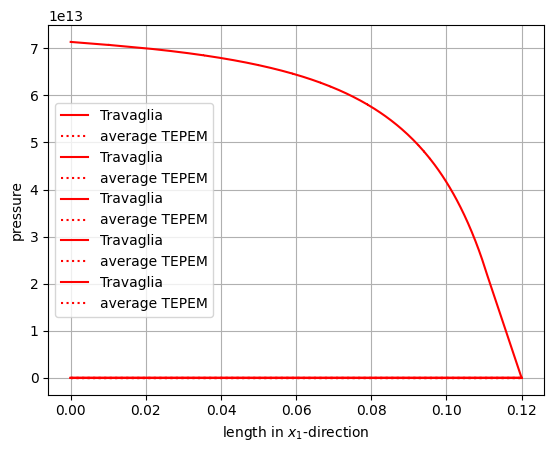

In [11]:
fig, ax = plt.subplots()
plot_pressure_overview(ax=ax, x_p_elena=x_e, p_elena=p_e, x_p_tepem=x_t, p_tepem=p_t)

In [16]:
def get_pressure_summary(pressures_elena: list[npt.NDArray[np.float64]], pressures_tepem: list[npt.NDArray[np.float64]]):
    inlet_p_elena = []
    inlet_p_tepem = []
    for p_e, p_t in list(zip(pressures_elena, pressures_tepem)):
        inlet_p_elena.append(get_inlet_pressures(p_e))
        inlet_p_tepem.append(get_inlet_pressures(p_t, elena_data=False))
    inlet_p_elena.sort()
    inlet_p_tepem.sort() 
    inlet_e = np.array(inlet_p_elena)
    inlet_t = np.array(inlet_p_tepem)
    difference = np.absolute(inlet_e - inlet_t)
    average = inlet_e + inlet_t / 2
    rel_diff = difference / average * 100
    output = ""
    for i, value in enumerate(rel_diff):
        specific_output = f"elena: {inlet_e[i]}, tepem: {inlet_t[i]}, difference: {value}\n"
        output += specific_output
    return output



print(get_pressure_summary(p_e, p_t))

elena: 34.37584, tepem: 34.27164401801201, difference: 0.20227649026305525
elena: 343.76, tepem: 342.71644018012, difference: 0.20258647028589644
elena: 3433.919, tepem: 3427.1644018012007, difference: 0.13122091545345113
elena: 34013.27, tepem: 34271.64401801201, difference: 0.5051390119819176
elena: 71347020000000.0, tepem: 3427164.4018011983, difference: 99.99999279472853

